In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
import sys
import os

basedrive = "drive/My Drive/upper limb use assessment"
os.chdir(basedrive)
sys.path.append("scripts")

In [3]:
!pip install ahrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.9/197.9 KB 5.3 MB/s eta 0:00:00


In [4]:
!pip install scikit-learn==0.23

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 38.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.0 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.0 which is incompatible.


In [5]:
!pip install scikit-posthocs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import sys
sys.path.append("../scripts")  

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

In [2]:
import misc

In [3]:
import pandas as pd 
pd.__version__

'2.0.3'

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import signal

In [5]:
l, r = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Pitch

In [6]:
def compute_tilt(ax, freq):
  w = round(freq)
  ax = np.append(np.ones(w-1)*ax[0], ax)

  # moving average filter
  ax = np.convolve(ax, np.ones(w), 'valid') / w

  ax[ax<-1] = -1
  ax[ax>1] = 1
  return -np.rad2deg(np.arccos(ax))+90

In [7]:
ax = r[r.subject==1].ax.values
pitch_hat = compute_tilt(ax, 50)
pitch = r[r.subject==1].pitch.values

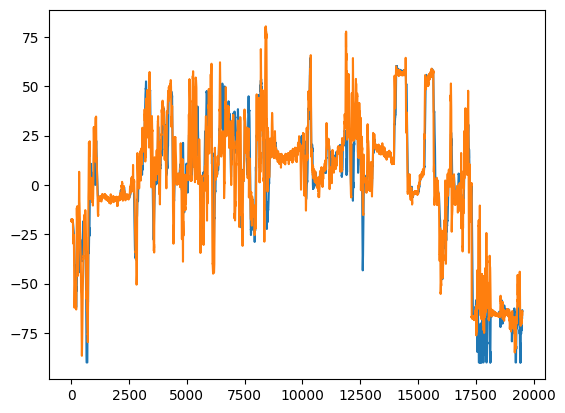

In [8]:
plt.plot(pitch_hat)
plt.plot(pitch)

Text(0, 0.5, 'pitch')

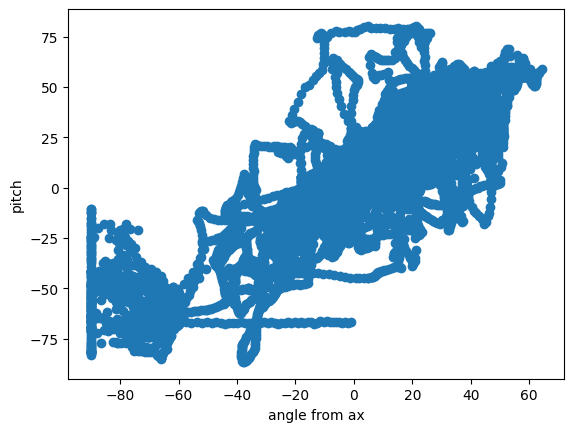

In [9]:
plt.scatter(pitch_hat, pitch)
plt.xlabel('angle from ax')
plt.ylabel('pitch')

In [10]:
pearsonr(pitch, pitch_hat)

PearsonRResult(statistic=0.9046985706407812, pvalue=0.0)

# Activity counts

In [11]:
counts = (ca.compute_vector_magnitude(r[r.subject==1], fs=30)).counts.values
ax = r[r.subject==1].ax
ay = r[r.subject==1].ay
az = r[r.subject==1].az

In [12]:
b, a = signal.butter(2, 1/(2*50), 'high')
ax_filt = signal.filtfilt(b, a, ax)
ay_filt = signal.filtfilt(b, a, ay)
az_filt = signal.filtfilt(b, a, az)

ax_filt[np.abs(ax_filt)<0.068] = 0
ay_filt[np.abs(ay_filt)<0.068] = 0
az_filt[np.abs(az_filt)<0.068] = 0

amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
amag = [sum(amag[i:i+50]) for i in range(0, len(amag), 50)]
w = 5
amag = np.append(np.ones(w-1)*amag[0], amag)

# moving average filter
amag = np.convolve(amag, np.ones(w), 'valid') / w

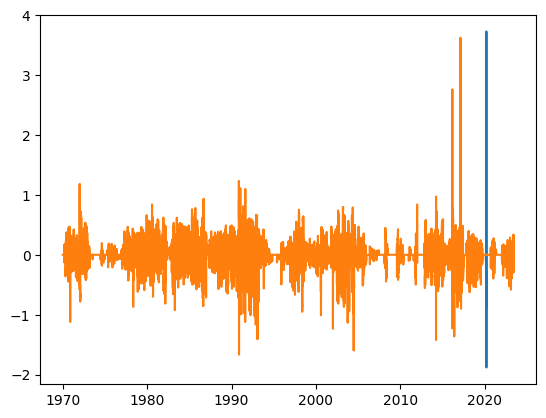

In [13]:
plt.plot(ax)
plt.plot(ax_filt)

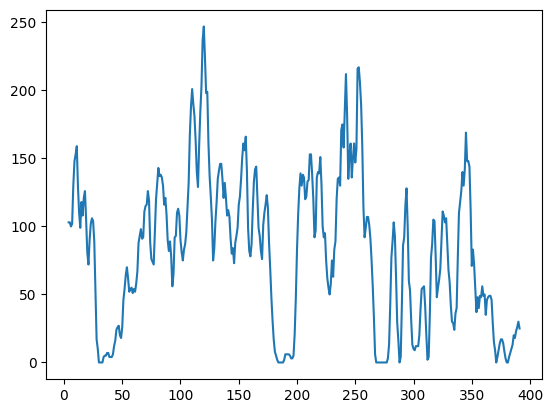

In [14]:
plt.plot(counts)

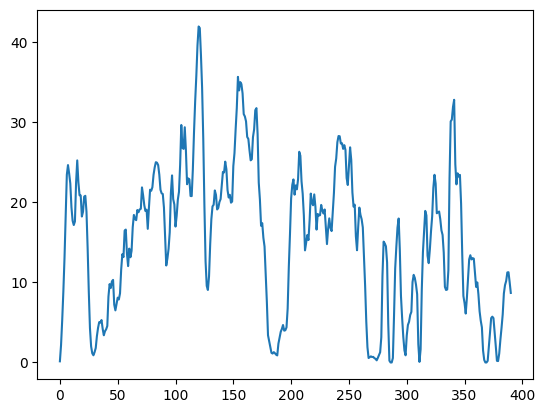

In [15]:
plt.plot(amag)

In [24]:
counts[np.isnan(counts)] = 0

Text(0, 0.5, 'counts')

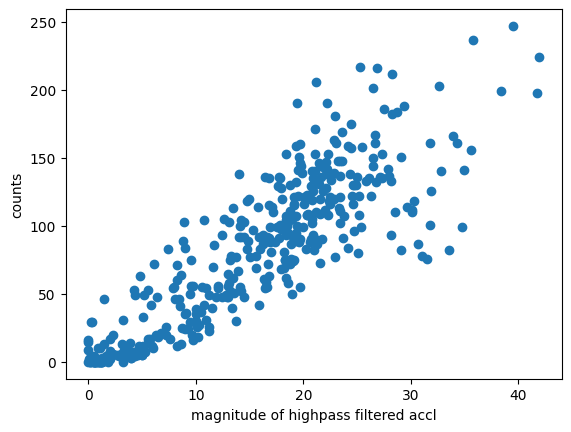

In [16]:
plt.scatter(amag, counts[1:])
plt.xlabel('magnitude of highpass filtered accl')
plt.ylabel('counts')

In [ ]:
pearsonr(amag, counts[1:])

(0.8822045564601536, 2.618118077333752e-129)

# GMAC

In [36]:
gmac = [1 if np.abs(pitch) < 30 and count > 0 else 0 for pitch, count in zip(pitch_hat[0:len(pitch_hat):50], amag)]
gnd = [r[r.subject==1].gnd[i] for i in range(0, len(r[r.subject==1]), 50)]

In [41]:
ca.confmatrix(gmac, gnd)

,true positive,false positive,false negative,true negative,accuracy,gwets ac1 score,sensitivity,specificity,precision,f1 score,balanced accuracy
0,0.58312,0.120205,0.16624,0.130435,0.713555,0.524543,0.778157,0.520408,0.829091,0.802817,0.649283


In [33]:
gmac_original = (ca.get_gm_modified(r[r.subject==1])).pred.values

In [42]:
ca.confmatrix(gmac_original, gnd[1:])

,true positive,false positive,false negative,true negative,accuracy,gwets ac1 score,sensitivity,specificity,precision,f1 score,balanced accuracy
0,0.54359,0.110256,0.207692,0.138462,0.682051,0.453757,0.723549,0.556701,0.831373,0.773723,0.640125


# optimizing parameters 

In [ ]:
def compute_gmac(ax, ay, az, freq=50, pitch_threshold=30, counts_threshold=0, hpf_cutoff=1, pitch_window=1, counts_window=5):
  w = pitch_window*round(freq)
  ax = np.append(np.ones(w-1)*ax[0], ax)

  # moving average filter
  ax = np.convolve(ax, np.ones(w), 'valid') / w

  ax[ax<-1] = -1
  ax[ax>1] = 1
  pitch = -np.rad2deg(np.arccos(ax))+90

  b, a = signal.butter(2, hpf_cutoff/(2*freq), 'high')
  ax_filt = signal.filtfilt(b, a, ax)
  ay_filt = signal.filtfilt(b, a, ay)
  az_filt = signal.filtfilt(b, a, az)

  deadband_threshold = 0.068
  ax_filt[np.abs(ax_filt)<deadband_threshold] = 0
  ay_filt[np.abs(ay_filt)<deadband_threshold] = 0
  az_filt[np.abs(az_filt)<deadband_threshold] = 0

  amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
  amag = [sum(amag[i:i+freq]) for i in range(0, len(amag), freq)]
  w = counts_window
  amag = np.append(np.ones(w-1)*amag[0], amag)

  # moving average filter
  amag = np.convolve(amag, np.ones(w), 'valid') / w

  gmac = [1 if np.abs(pitch) < pitch_threshold and count > counts_threshold else 0 for pitch, count in zip(pitch_hat[0:len(pitch_hat):freq], amag)]
  return gmac